
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score


In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [3]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [4]:
ha.dtypes


,0
age,int64
sex,int64
cp,int64
trtbps,int64
chol,int64
restecg,int64
thalach,int64
output,int64


In [5]:
ha.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [47]:
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

X = ha.drop(["cp"], axis = 1)
y = ha['cp']

ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output = False), ["sex", "restecg", "output"]),
    ],
    remainder = "passthrough"
).set_output(transform = "pandas")


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

y_pred_knn = knn.predict(X)

print("KNN Classification Report:")
print(classification_report(y, y_pred_knn))



KNN Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.91      0.74       128
           1       0.50      0.39      0.44        44
           2       0.67      0.41      0.51        81
           3       1.00      0.25      0.40        20

    accuracy                           0.63       273
   macro avg       0.70      0.49      0.52       273
weighted avg       0.65      0.63      0.60       273



In [48]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': range(1, 21),
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters found: {'knn__n_neighbors': 18, 'knn__weights': 'uniform'}
Best cross-validation accuracy: 0.5457912457912458


In [49]:
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X, y)

y_pred = best_model.predict(X)

print(f"Test Accuracy: {test_accuracy}")
print(classification_report(y, y_pred))

Test Accuracy: 0.575091575091575
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       128
           1       0.40      0.23      0.29        44
           2       0.46      0.51      0.48        81
           3       0.00      0.00      0.00        20

    accuracy                           0.58       273
   macro avg       0.38      0.39      0.38       273
weighted avg       0.51      0.58      0.54       273



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

pipeline_dt = Pipeline(steps=[
    ('preprocessor', ct),
    ('decision_tree', DecisionTreeClassifier(max_depth=5, random_state=42))
])

param_grid = {
    'decision_tree__max_depth': [3, 5, 10, None],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 5]

grid_search = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

print("Best Parameters Found:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters Found: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_leaf': 5, 'decision_tree__min_samples_split': 2}
Best Cross-Validation Accuracy: 0.48740740740740734


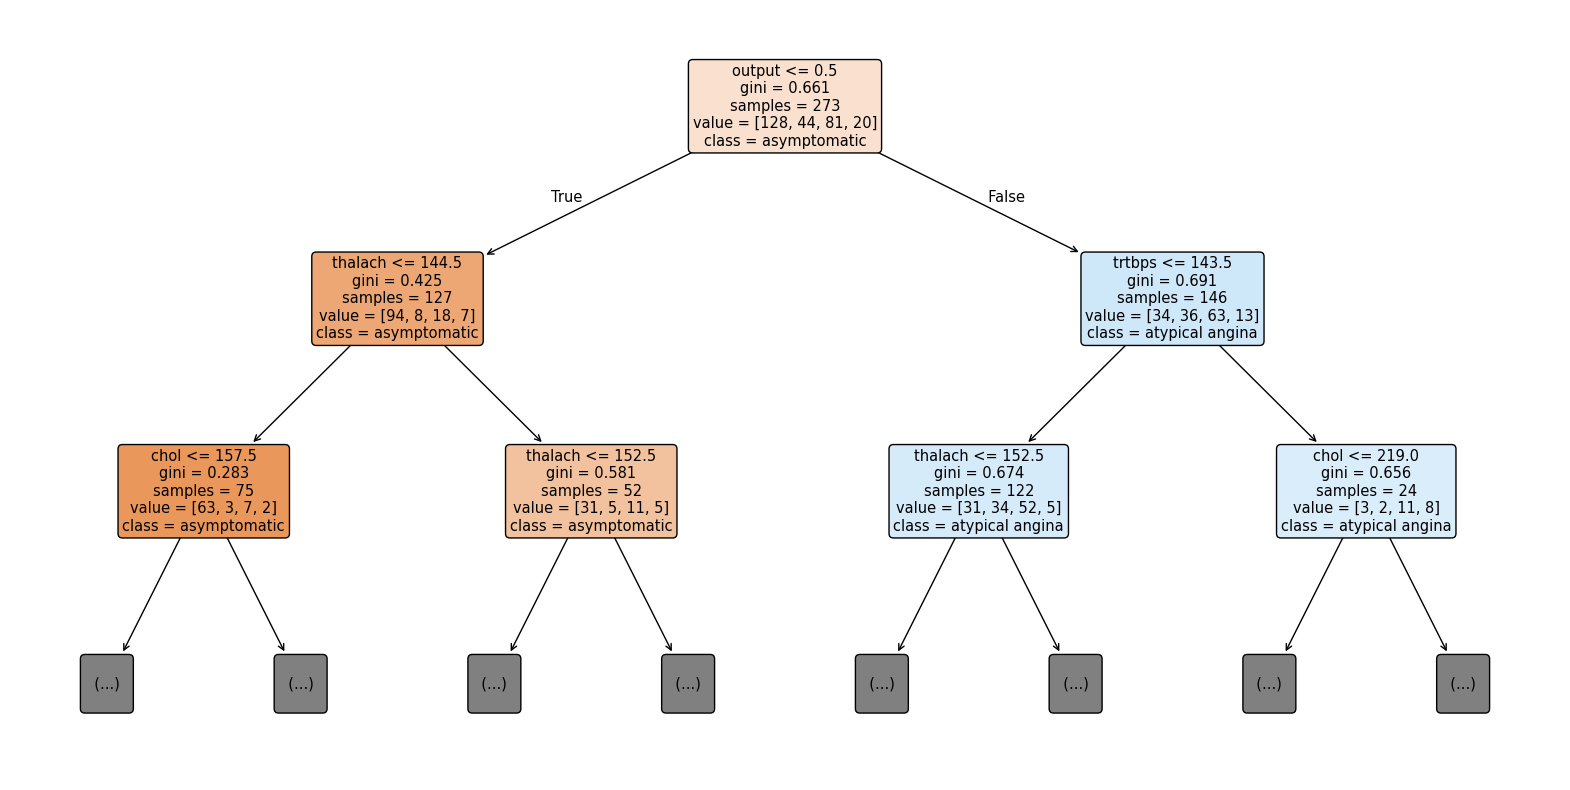

In [55]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline([("dt", DecisionTreeClassifier(max_depth=3))])
fitted_pipeline_dt1 = pipeline_dt.fit(X, y)
fitted_pipeline_dt1

decision_tree_model = fitted_pipeline_dt1.named_steps['dt']

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model,
          filled=True,
          rounded=True,
          class_names=["asymptomatic", "typical angina", "atypical angina", "non-anginal pain"],
          feature_names=X.columns,
          max_depth=2) # The first two splits
plt.show()

### **Root Node (First Split)**
- **Feature**: `output` (doctor's diagnosis of heart attack risk).
- **Condition**: `output <= 0.5`
  - Patients not at risk (`output = 0`) go left; those at risk (`output = 1`) go right.
- **Class Distribution**: `[128, 44, 81, 20]` (majority class: `0`, asymptomatic chest pain).
- **Predicted Class**: **Class 0** (asymptomatic chest pain).

---

### **Second Split**
#### **Left Child Node (Patients Not at Risk)**
- **Feature**: `thalach` (maximum heart rate).
- **Condition**: `thalach <= 144.5`
  - Lower heart rate leads to **class 0** (asymptomatic chest pain).
- **Class Distribution**: `[94, 8, 18, 7]`.

#### **Right Child Node (Patients At Risk)**
- **Feature**: `trtbps` (resting blood pressure).
- **Condition**: `trtbps <= 143.5`
  - Lower blood pressure leads to **class 2** (atypical angina).
- **Class Distribution**: `[34, 36, 63, 13]`.

The decision tree first splits patients based on their risk of a heart attack (`output`), distinguishing those not at risk (dominated by asymptomatic chest pain) from those at risk. Subsequent splits refine predictions using key features like heart rate (`thalach`) and blood pressure (`trtbps`), highlighting their importance in classifying chest pain types.

In [61]:
pipeline_lda = Pipeline(steps=[
    ('preprocessor', ct),
    ('lda', LinearDiscriminantAnalysis())
])

# Parameter grid for GridSearchCV
param_grid_lda = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],
    'lda__shrinkage': [None, 'auto', 0.1, 0.2, 0.5],
    'lda__n_components': [1, 2, 3]
}

grid_search_lda = GridSearchCV(
    estimator=pipeline_lda,
    param_grid=param_grid_lda,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_lda.fit(X, y)

print("Best Parameters Found:", grid_search_lda.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_lda.best_score_)



Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters Found: {'lda__n_components': 1, 'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.5532659932659932


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

In [63]:


best_lda_model = grid_search_lda.best_estimator_
y_pred_lda = best_lda_model.predict(X)

print(classification_report(y, y_pred_lda))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       128
           1       0.33      0.09      0.14        44
           2       0.45      0.69      0.54        81
           3       0.40      0.10      0.16        20

    accuracy                           0.58       273
   macro avg       0.48      0.41      0.40       273
weighted avg       0.56      0.58      0.55       273



## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [64]:
import numpy as np

# Create new columns for each 'cp' category
ha['cp_is_1'] = np.where(ha['cp'] == 1, 1, 0)
ha['cp_is_2'] = np.where(ha['cp'] == 2, 1, 0)
ha['cp_is_3'] = np.where(ha['cp'] == 3, 1, 0)
ha['cp_is_4'] = np.where(ha['cp'] == 4, 1, 0)

# Display the updated dataframe
ha.head()


,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_1,cp_is_2,cp_is_3,cp_is_4
0,63,1,3,145,233,0,150,1,0,0,1,0
1,37,1,2,130,250,1,187,1,0,1,0,0
2,56,1,1,120,236,1,178,1,1,0,0,0
3,57,0,0,120,354,1,163,1,0,0,0,0
4,57,1,0,140,192,1,148,1,0,0,0,0


In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

categories = ha["cp"].unique()
f1_scores = {}

for category in categories:
    ha[f"cp_is_{category}"] = (ha["cp"] == category).astype(int)

    X = ha.drop(columns=["cp"] + [f"cp_is_{cat}" for cat in categories])
    y = ha[f"cp_is_{category}"]

    model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    model.fit(X, y)

    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)

    f1_scores[category] = f1

    print(f"Category {category}: F1 Score = {f1:.4f}")

best_category = max(f1_scores, key=f1_scores.get)
print("\nBest Distinguished Category:")
print(f"Category {best_category} with F1 Score = {f1_scores[best_category]:.4f}")




Category 3: F1 Score = 0.2295
Category 2: F1 Score = 0.5511
Category 1: F1 Score = 0.3899
Category 0: F1 Score = 0.7385

Best Distinguished Category:
Category 0 with F1 Score = 0.7385


Based on the F1 scores, the One-vs-Rest (OvR) approach was most effective at distinguishing **Category 0 (asymptomatic chest pain)**, with an F1 score of 0.7385. This result indicates that the Logistic Regression model was best at identifying whether a patient's chest pain is **asymptomatic** or not.

This makes sense because asymptomatic chest pain is often distinctly different from other types of chest pain, as it typically lacks observable symptoms during physical exertion. The feature values associated with asymptomatic cases may be more consistent and separable compared to the overlapping characteristics of other chest pain types like typical or atypical angina, or non-anginal pain. Thus, the model can more confidently predict this category, leading to a higher F1 score.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd

categories = ha["cp"].unique()
roc_auc_scores = {}

for category in categories:
    ha[f"cp_is_{category}"] = (ha["cp"] == category).astype(int)

    X = ha.drop(columns=["cp", f"cp_is_{category}"])
    y = ha[f"cp_is_{category}"]

    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X, y)

    y_pred_proba = model.predict_proba(X)[:, 1]

    auc = roc_auc_score(y, y_pred_proba)
    roc_auc_scores[category] = auc

    print(f"Category {category}: ROC-AUC = {auc:.4f}")

best_category = max(roc_auc_scores, key=roc_auc_scores.get)
print("\nBest Distinguished Category:")
print(f"Category {best_category} with ROC-AUC = {roc_auc_scores[best_category]:.4f}")


Category 3: ROC-AUC = 0.7474
Category 2: ROC-AUC = 0.7485
Category 1: ROC-AUC = 0.8998
Category 0: ROC-AUC = 1.0000

Best Distinguished Category:
Category 0 with ROC-AUC = 1.0000


The ROC-AUC scores indicate that **Category 0 (asymptomatic chest pain)** was best distinguished from the others with a perfect score of **1.0000**, showing it is entirely separable based on the given features. **Category 1 (typical angina)** had the next highest ROC-AUC at **0.8998**, suggesting it is also relatively distinguishable from the rest. Categories **2 (atypical angina)** and **3 (non-anginal pain)** had lower scores of **0.7485** and **0.7474**, respectively, indicating more overlap or difficulty in distinguishing these from other types of chest pain. This suggests that asymptomatic chest pain has distinct feature patterns, making it the easiest for the logistic regression model to identify.